<a href="https://colab.research.google.com/github/RegisKonan/FinalProject/blob/main/regis_konan_AMM_Foundations_of_ML%2C_Locally_weighted_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Locally Weighted Regression

In this tutorial you will implement locally weighted regression (LWR) and understand the differences between LWR and linear regression.

The idea behind locally weighted regression (LWR) is to fit linear model in a local region about the point we want to do prediction at.
More formally, given the point $x$ at which we want to predict the output, we minimize the following loss function:
$$
\begin{align}
L(\theta) &= \sum_{i=1}^{N} w(x_i) (y_i - \theta^Tx_i)^2 \\
& = (X \theta - y)^T W (X \theta - y)
\end{align}
$$

\begin{equation}
X = \begin{bmatrix}
     - (x^{(1)})^T - \\
     \vdots \\
     - (x^{(n)})^T - \\
     \end{bmatrix}
     \in \mathbb{R}^{m \times n}
\qquad
y = \begin{bmatrix}
     y^{(1)} \\
     \vdots \\
     y^{(n)} \\
     \end{bmatrix}
\qquad
W =  \mathrm{diag} (w^{(i)}, \dots , w^{(n)})
\end{equation}

Where $w(x_i)$ is a weghting function, the purpose of this function is control the importance of each training example $(x_i, y_i)$ relative to the prediction point $x$, points which are close to $x$ will have larger weights while points which are far away from $x$ will have smaller weights.

A common choice of $w(x_i)$ is of the following form
$$
w(x_i) = \exp(-\frac{(x_i-x)^2}{2 \tau^2})
$$
Notice that when the example $x_i$ is close to the prediction point $x$ the weight is close to 1, and if $x_i$ is far away from $x$ the weight is close to 0.
$\tau$ controls the decay rate in which the weight falls from 1 to 0, the smaller the value of $\tau$ the quciker the weight falls to 0 as the point $x_i$ move further away from $x$, you can play interactively with in the next cell to understand the affect of $\tau$, $\tau$ is called the bandwidth parameter.


We can solve for $\theta$ with a slightly modified version of the normal equations
$$\theta = (X^T W X)^{-1} X^T W y$$

In [ ]:
#@title Install some dependencies for the interactive plot
!pip install ipympl
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title Interactive plot for the weight function

import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import numpy as np

@interact
def f(tau=widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1)):
  x = 0
  x_i = np.arange(-10, 10, 0.1)
  w = np.exp(- (x_i - x)**2/(2*tau**2) )
  f = go.Figure(data=go.Line(x=x_i, y=w, mode='lines'))
  f.update_layout(yaxis_range=[0,1.2], width=500, height=500, title=r"$w(x_i) = \exp(-\frac{(x_i-x)^2}{2 \tau^2}), \ x=0$", xaxis_title="X value", yaxis_title="W value")
  f.show()


interactive(children=(FloatSlider(value=1.0, description='tau', max=5.0, min=0.1), Output()), _dom_classes=('w…

After playing with the weighting function, write your observations in the next cell

In [ ]:
# Your comments

# Training Data

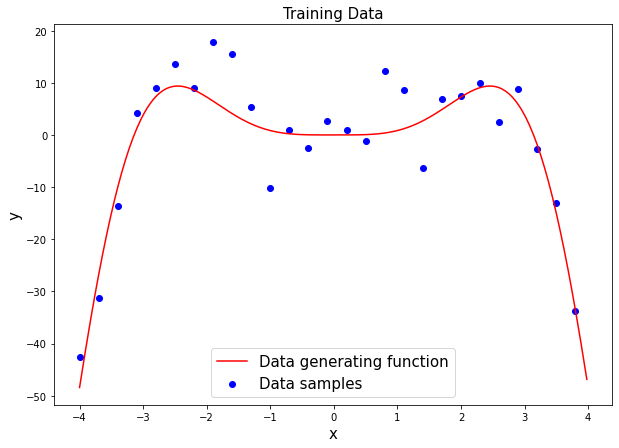

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 7)
matplotlib.rcParams['legend.fontsize'] = 15
import numpy as np

def generate_data(add_outlier=False):
  x = np.arange(-4, 4, 0.03)
  # if add_outlier:
  #   x = np.concatenate([x, [3, 5, 1]], axis=0)
  y =  x**3*np.sin(x)
  # y = 2*x
  plt.plot(x, y, label="Data generating function", color="red")
  x = np.arange(-4, 4, 0.3)
  # if add_outlier:
  #   x = np.concatenate([x, [3, 5, 1]], axis=0)
  y =  x**3*np.sin(x)
  noise = np.random.randn(x.shape[0]) * 5
  y += noise
  if add_outlier:
    x = np.concatenate([x, [3, 5, -1, 1, 0]], axis=0)
    y = np.concatenate([y, [300, 200, 100, -100, 500]], axis=0)
  plt.scatter(x, y, label="Data samples", color="blue")
  font = {"size":15}
  plt.legend()
  plt.xlabel("x", fontdict=font)
  plt.ylabel("y", fontdict=font)
  plt.title("Training Data", fontdict=font)
  return x.reshape(-1, 1), y.reshape(-1, 1)
  

x_train, y_train = generate_data()

In [ ]:
x_train.shape

(27, 1)

# LWR Model




In [ ]:
from os import XATTR_CREATE
class LWR:
  def __init__(self, lr, tau):
    # lr: learning rate
    # epochs: training
    # tau: bandwidth parameter
    self.lr = lr
    self.theta = None
    self.tau = tau


  def add_ones(self, x):
    # add ones to the front of each feature vector to account for the bias term 
    # save the value in x_with_ones, for the tutorial dataset the shape should be (batch_size, 2)
    one = np.ones((x.shape[0], 1))
    # print(one.shape, x.shape)
    x_with_ones = np.hstack((one, x))
    ##### write your code here #####

    ##### End of your code #####
    return x_with_ones

  
  def _weighting_function(self, x_pred):
    # Implement the weighting function w(x_i) as described above and store the value in w_matrix
    # w_matrix is diagonal matrix with shape (batch_size, batch_size)
    # x_pred: prediction point
    #w_matrix = None
    w_func= np.exp(-((np.linalg.norm((x_train - x_pred), axis = 1)**2)/2*self.tau**2)) # The shape of w should be ...
    w_matrix = np.diag(w_func)
    ##### write your code here #####

    ##### End of your code #####
    # Hint: to construct a digonal matrix use np.diag
    return w_matrix


  def fit(self,x_train, y_train):
    # Save the traing examples as class attributes
    # Method parameters:
    # x_train: The input features
    # y_train: The output targets
    ##### write your code here #####
    self.x_train = x_train
    self.y_train = y_train

    ##### End of your code #####
    return None


  def predict(self, x_pred):
    # Predict the output given x_pred
    # add ones to the training and predicton points
    # Compute the weights matrix
    # compute the model parameters with the normal equations described above
    # return y_pred

    x_train_one = self.add_ones(self.x_train)
    x_pred_one = self.add_ones(x_pred)
    w_matrix = self._weighting_function(x_pred_one)
    # print(x_train_one.shape, w_matrix.shape, y_train.shape)
    self.theta = np.linalg.inv(x_train_one.T@w_matrix@x_train_one)@x_train_one.T@w_matrix@self.y_train
    # print(self.theta.shape, x_pred_one.shape)
    #print(x_pred_one.T.shape)
    y_pred = self.theta.T @ x_pred_one.T
    ##### write your code here #####
    
    
    ##### End of your code #####
    return y_pred

In [ ]:
x_pred = np.arange(-4, 4, 0.03)
model=LWR(x_pred, tau=0.5)
model._weighting_function( x_pred)

array([[5.59952199e-309, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.39206475e-275, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+0

In [ ]:
# Now train the locally weighted regression model that you coded
# Define the model
# use the fit function to save the x and y training data
# use the prediction function to compute predictions
# use a foor loop for predicting each value in x_pred, save it y_preds
x_pred = np.arange(-4, 4, 0.03)
y_preds = []
##### write your code here #####
model = LWR(lr=0.01,tau=1)
model.fit(x_train,y_train)

# for loop
for x in x_pred:
   y_pred = model.predict(x.reshape(-1,1))
   y_preds.append(y_pred[0,0])
  # predict(self, x_pred)
##### End of your code #####
# Optional Challange: can you predict the value without for loop?

Plot the prediction output

In [ ]:
def plot(x_train, y_train, x_pred, y_pred):
  plt.figure()
  plt.plot(x_train, y_train, 'bx', label='label')
  plt.plot(x_pred, y_pred, 'ro', label='prediction')
  plt.suptitle("Training Set", fontsize=12)
  plt.legend(loc='upper left')

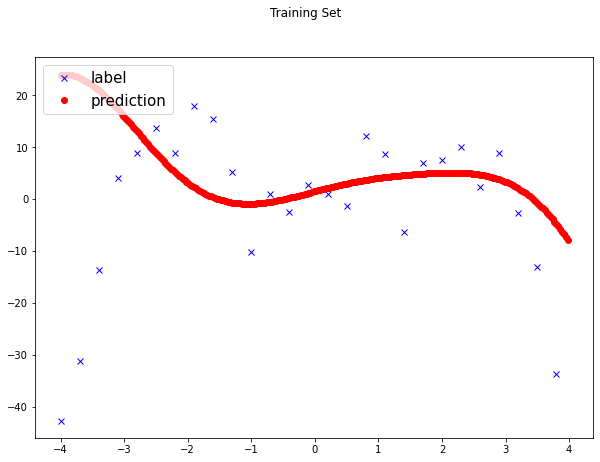

In [ ]:
# Use the plot function 
plot(x_train, y_train, x_pred, y_preds)

In [ ]:
# How tau affect the solution?
# Try different values of tau and observe the effect on the prediction by plotting them as above
# Write on observations as comment in the next cell

In [ ]:
# Your comments

# Robustness to outliers 

Locally weighting regression is better in handling outlier beucase the weighting function will give it a small weights

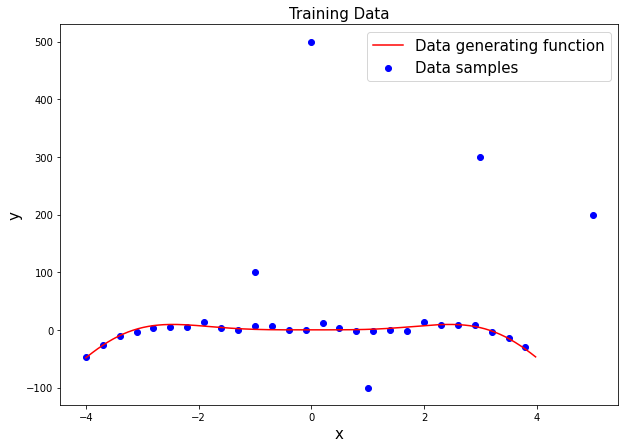

In [ ]:
# Generate dataset with 
x_train, y_train = generate_data(add_outlier=True)

In [ ]:
# train LWR on the new data and save the prediction values
lwr_preds = LWR(lr=0.01, tau=1)
##### write your code here #####

##### End of your code #####

In [23]:
# train LWR on the new data and save the prediction values
lwr_preds = LWR(0.01, 5)
x_pred = np.arange(-4, 4, 0.03)
y_preds = []
##### write your code here #####

lwr_preds.fit(x_train,y_train)

# for loop
for x in x_pred:
  pred = lwr_preds.predict(x.reshape(-1,1))
  y_preds.append(pred[0,0])
y_preds
##### End of your code #####

[25.577183333722843,
 20.62838196306803,
 14.979597509552192,
 8.175797578102234,
 -0.3284354002565051,
 -11.184391110037888,
 -25.139798399712078,
 -42.97663755403869,
 -65.36429347383671,
 -92.6131460581881,
 -124.37164810430534,
 -159.4026563067177,
 -195.6297917586092,
 -230.55104318022046,
 -261.8762630397358,
 -288.064005578982,
 -308.5099629909171,
 -323.39088710774627,
 -333.34453317230555,
 -339.1637797212881,
 -341.5873226990146,
 -341.1870918256202,
 -338.3181399136472,
 -333.0954618062058,
 -325.37299935512476,
 -314.71234233835867,
 -300.34121374553337,
 -281.1188745658185,
 -255.55280762098334,
 -221.94905520665964,
 -178.8069260260805,
 -125.52357135498741,
 -63.263467664089816,
 4.504091167289872,
 72.44099420251496,
 134.86575007681225,
 187.5457373818211,
 228.6521285537695,
 258.5349633956099,
 278.83637829995706,
 291.6092539033973,
 298.76156584741364,
 301.8224322725573,
 301.9063558976364,
 299.76377497083627,
 295.8520499298785,
 290.3981149097614,
 283.44556213

In [28]:
# compare the results with a linear regression model
from sklearn.linear_model import LinearRegression
##### write your code here #####
reg = LinearRegression().fit(x_train.reshape(-1, 1), y_train.reshape(-1, 1), )
linear_reg_preds = reg.predict(x_pred.reshape(-1, 1))
##### End of your code #####

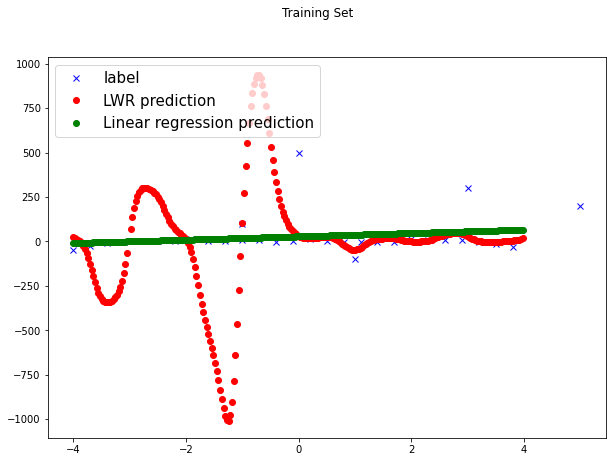

In [30]:
# Plot the predictins from LWR and linear regresson
plt.figure()
plt.plot(x_train, y_train, 'bx', label='label')
plt.plot(x_pred, y_preds, 'ro', label='LWR prediction')
plt.plot(x_pred, linear_reg_preds, 'go', label='Linear regression prediction')
plt.suptitle("Training Set", fontsize=12)
plt.legend(loc='upper left')

In [31]:
# How tau affect the sensitivity to outliers?
# Try different values of tau and observe the effect on the prediction by plotting them as above
# Write on observations as comment in the next cell

In [32]:
# Your comments